## Bitcoin and Ethereum price prediction with RNN LSTM


Importing needed libraries and installing Keras

In [0]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc

# import the relevant Keras modules
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

In [0]:
neurons = 1024
activation_function = 'tanh'
loss = 'mse'
optimizer="adam"
dropout = 2.5
batch_size = 128
epochs = 50
window_len = 7
training_size = 0.8
merge_date = '2016-01-01'
split_date = '2017-09-01'

In [0]:
def get_market_data(market, tag='None'):
  """
  market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'
  tag: eg.: 'btc', if provided it will add a tag to the name of every column.
  returns: panda DataFrame
  This function will use the coinmarketcap.com url for provided coin/token page. 
  Reads the OHLCV and Market Cap.
  Converts the date format to be readable. 
  Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.
  And finally tags each columns if provided.
  """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag != 'None':
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


def add_volatility(data, coins=['btc', 'eth']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['btc', 'eth'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  target_coin: the coin which will be the target for the prediction.
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X and it's label array Y from the given dataset and 
  will normalize 'Close' and 'Volume' between 0 and 1
  Return: X list and Y as numpy array
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

def create_outputs(data, coin, window_len=window_len):
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1

def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 2.5
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer)
  model.summary()
  return model

In [0]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()

In [0]:
btc_data = get_market_data("bitcoin", tag='btc')
eth_data = get_market_data("ethereum", tag='eth')

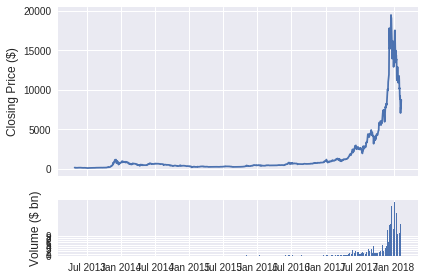

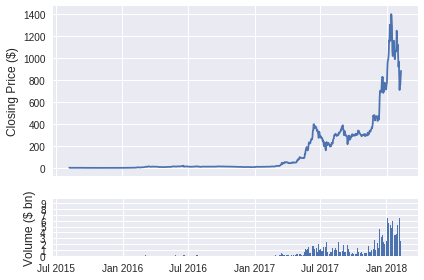

In [21]:
show_plot(btc_data, tag='btc')
show_plot(eth_data, tag='eth')

In [0]:
market_data = merge_data(btc_data, eth_data)
market_data = add_volatility(market_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [23]:
train_set.tail()

,Date,btc_Close,btc_Volume,btc_close_off_high,btc_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
159,2017-09-04,4236.31,2.987330e+09,0.470604,0.105241,295.17,1801690000,0.546659,0.193559
158,2017-09-05,4376.53,2.697970e+09,-0.761199,0.101632,312.99,1551050000,-0.778043,0.168969
157,2017-09-06,4597.12,2.172100e+09,-0.832710,0.054988,334.34,1058830000,-0.969769,0.067463
156,2017-09-07,4599.88,1.844620e+09,-0.326125,0.035673,329.43,718624000,-0.397644,0.040717
155,2017-09-08,4228.75,2.700890e+09,0.475709,0.127209,296.50,1098780000,0.490108,0.134935


In [24]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='btc')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='btc')

Y_train_eth = create_outputs(train_set, coin='eth')
Y_test_eth = create_outputs(test_set, coin='eth')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(610, 7, 8) (148, 7, 8) (610,) (148,)
(610, 7, 8) (148, 7, 8) (610,) (148,)


In [25]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 7, 1024)           4231168   
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 1024)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 7, 1024)           8392704   
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 1024)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
__________

610/610 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 11/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0083
Epoch 12/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 13/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 14/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 15/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 16/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 17/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 18/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 19/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0055
Ep

610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 30/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 31/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 32/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 33/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 34/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 35/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 36/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 37/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 38/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Ep

610/610 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 49/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 50/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0053


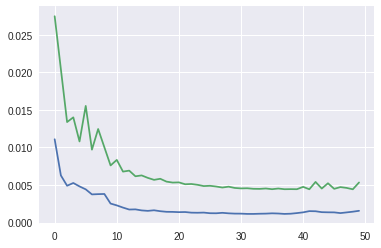

In [26]:
plt.plot(btc_history.epoch, btc_history.history['loss'])
plt.plot(btc_history.epoch, btc_history.history['val_loss'])
plt.show()

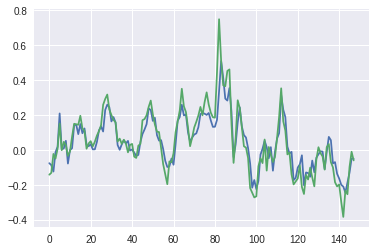

In [27]:
plt.plot(btc_model.predict(X_test))
plt.plot(Y_test_btc)
plt.show()

In [28]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 7, 1024)           4231168   
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 1024)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 7, 1024)           8392704   
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 1024)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1024)              8392704   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
__________

610/610 [==============================] - 1s 1ms/step - loss: 0.0120 - val_loss: 0.0061
Epoch 11/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0061
Epoch 12/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0057
Epoch 13/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0059
Epoch 14/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 15/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 16/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0054
Epoch 17/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 18/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0082 - val_loss: 0.0053
Epoch 19/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0054
Ep

610/610 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 30/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 31/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 32/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 33/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 34/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 35/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 36/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 37/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0051
Epoch 38/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0052
Ep

610/610 [==============================] - 1s 1ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 49/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 50/50
610/610 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0053


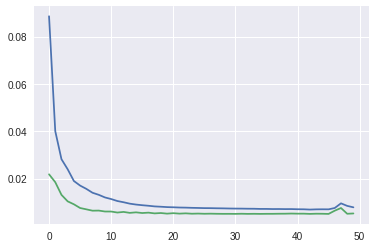

In [29]:
plt.plot(eth_history.epoch, eth_history.history['loss'])
plt.plot(eth_history.epoch, eth_history.history['val_loss'])
plt.show()

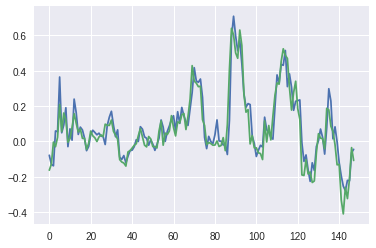

In [30]:
plt.plot(eth_model.predict(X_test))
plt.plot(Y_test_eth)
plt.show()